# Discussion with Dan 

In [4]:
from GP_recovery import *

In [163]:
Nr = 1
t = np.linspace(0, 2000, 2001)
# t = np.linspace(0, 700, 701)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
y = y[0,:]
t.shape, y.shape

((2001,), (2001,))

In [164]:
t_int = []
y_int = []
for i in range(2000//(60*8)):
    if i%3 == 0:
        idx =  (t >= i*60*8) & (t < (i+1)*60*8)
        t_int.append(t[idx])
        y_int.append(y[idx])

In [171]:
t_int = np.array(t_int)
t_int = t_int.flatten()
y_int = np.array(y_int)
y_int = y_int.flatten()

In [172]:
t_int.shape

(960,)

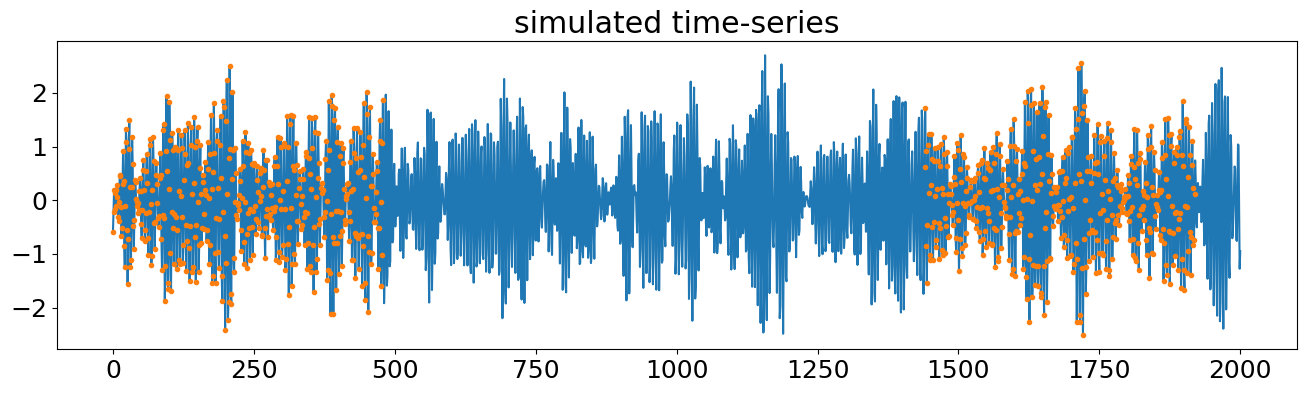

In [174]:
plt.figure(figsize=(16, 4))
plt.title('simulated time-series')
# plt.xlim([0,700])
plt.plot(t, y)
plt.plot(t_int.T, y_int.T, '.')
plt.show()

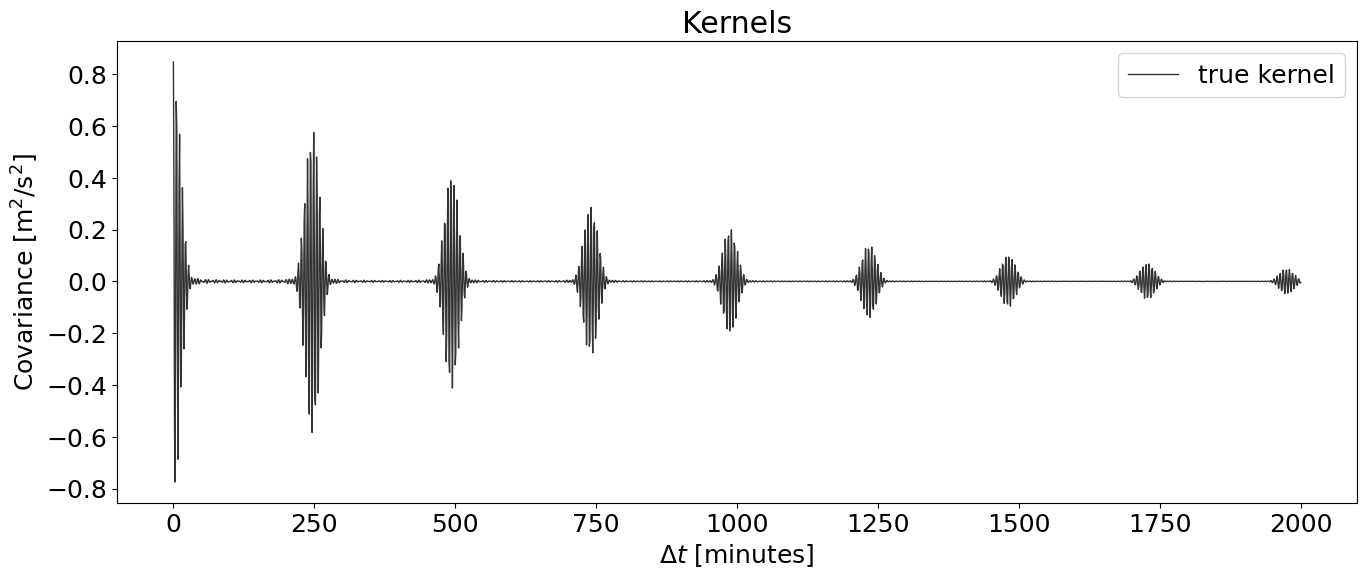

In [175]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.show()

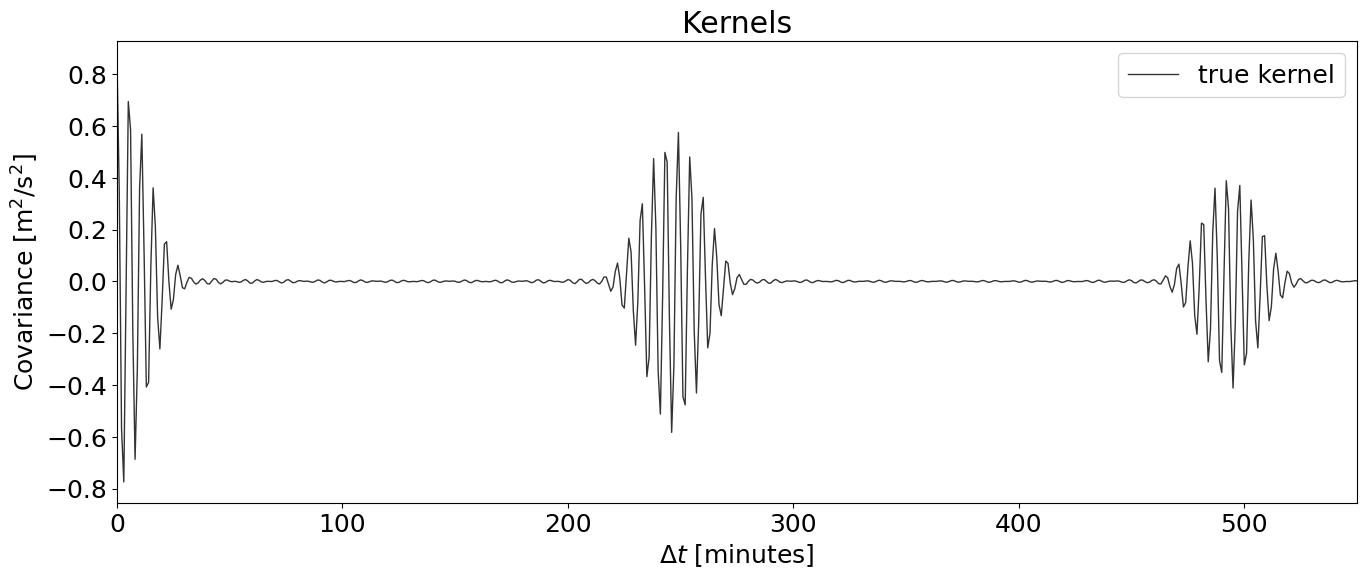

In [176]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([0,550])
plt.legend()
plt.show()

In [266]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -2372.940223068359
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-476.54767601, dtype=float64)}


# Performance

### Q

In [268]:
def solve():
    w_init = jnp.zeros(len(theta_init))
    lower_bounds = jnp.ones_like(w_init)* (-1)
    upper_bounds = jnp.ones_like(w_init) * jnp.inf
    bounds = (lower_bounds, upper_bounds)

    import jaxopt
    solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
    soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

    for key, value in soln.params.items():
        print(key[4:], np.exp(value))
    
    model_gp, _ = build_gp(soln.params, t)
    
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(16, 6))
    plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
    plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
    plt.title('Kernels')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.xlim([0,700])
    plt.legend()
    plt.show()

Final negative log likelihood: -2558.2200458549
Q 400.8029975017935


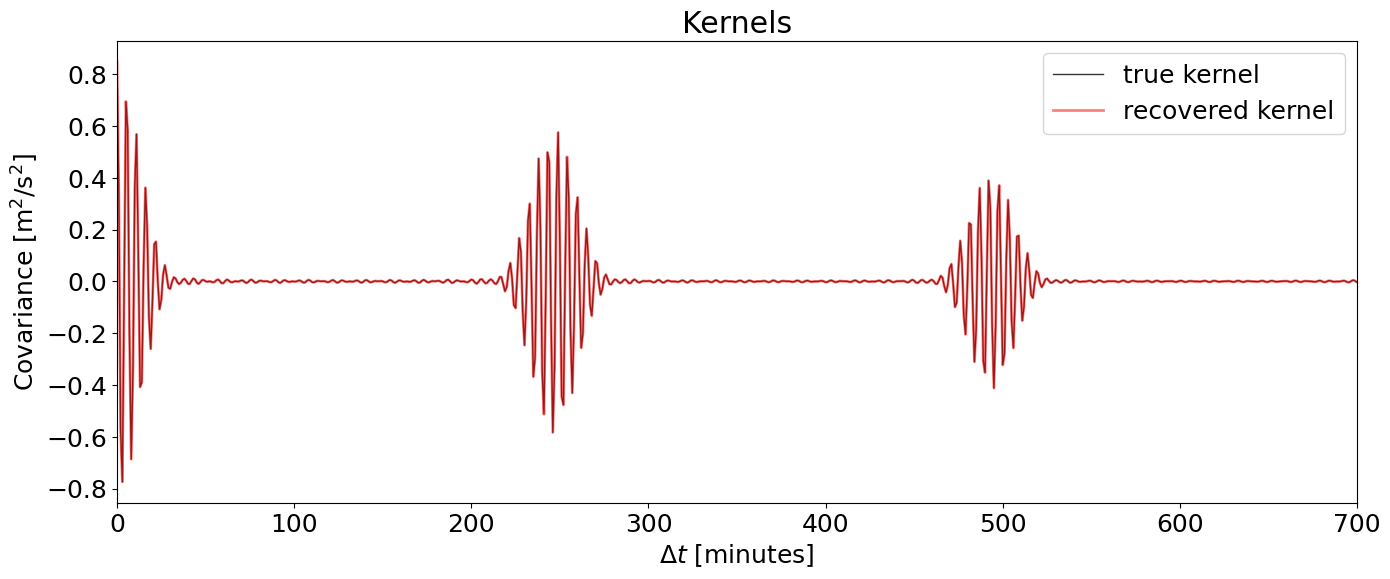

In [269]:
 solve()

In [270]:
idx_test = ((t > 450) & (t < 500))
t_train = t[~idx_test]
y_train = y[~idx_test]

In [271]:
gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

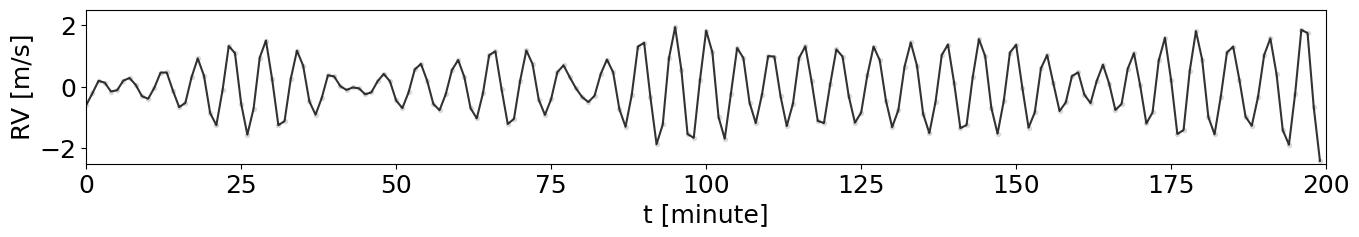

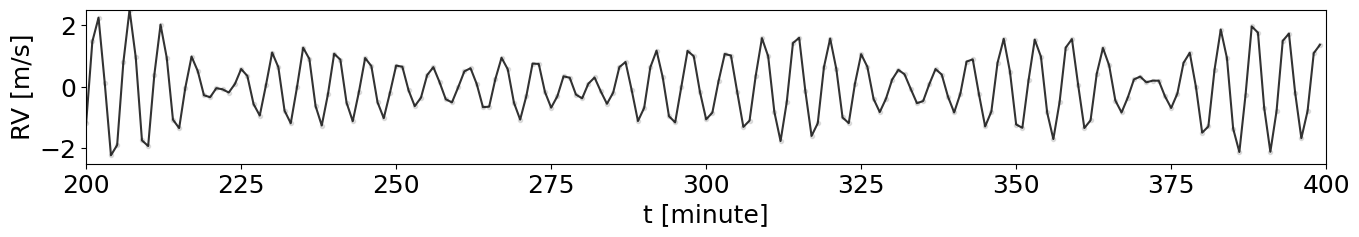

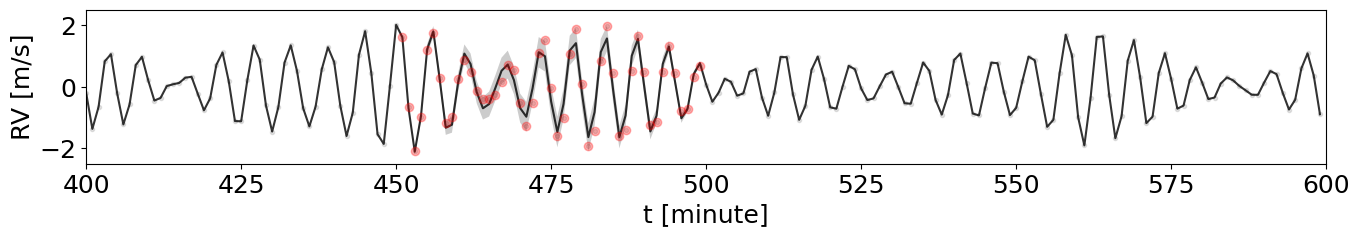

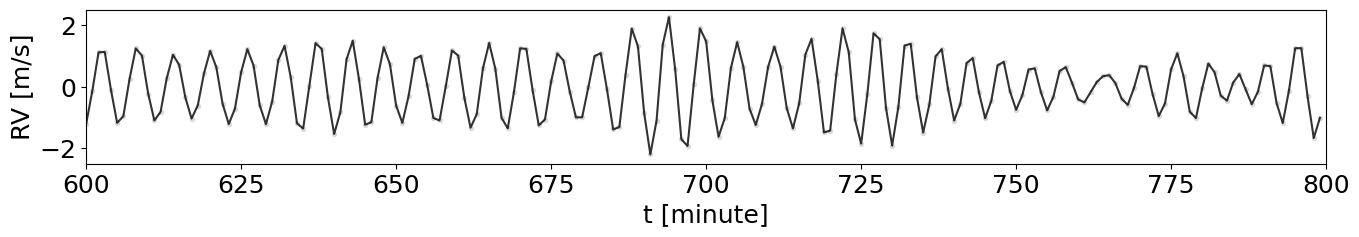

In [272]:
for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

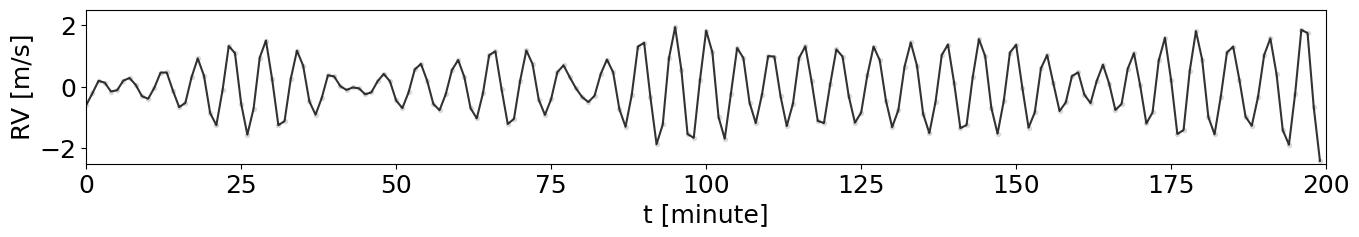

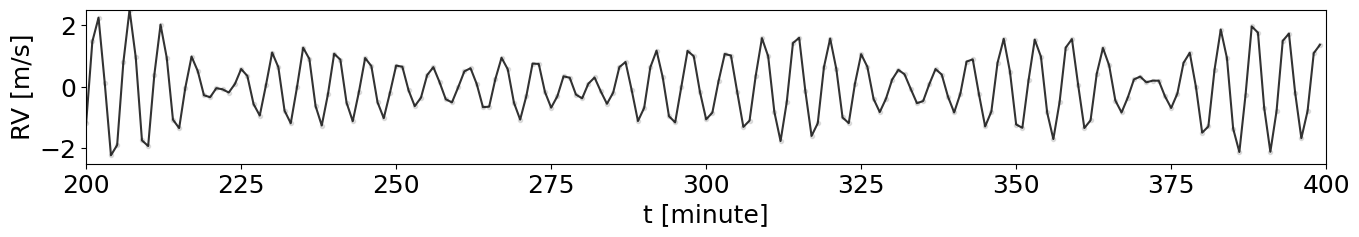

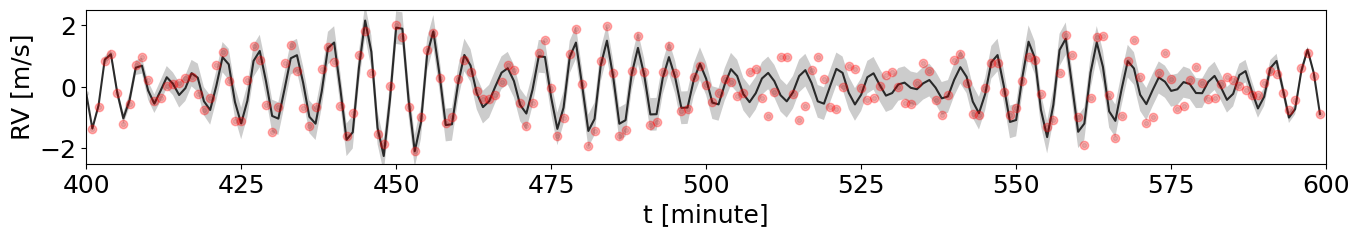

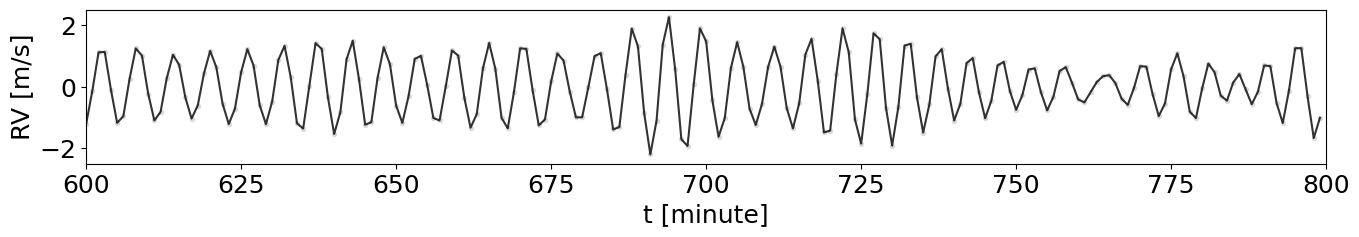

In [273]:
idx_test = ((t > 400) & (t < 600))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

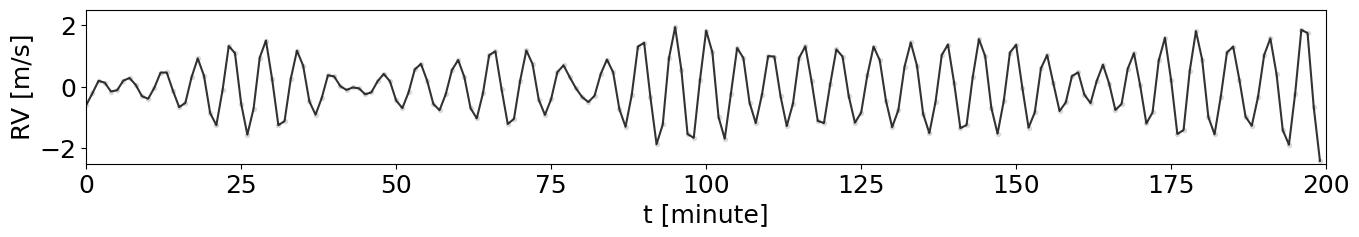

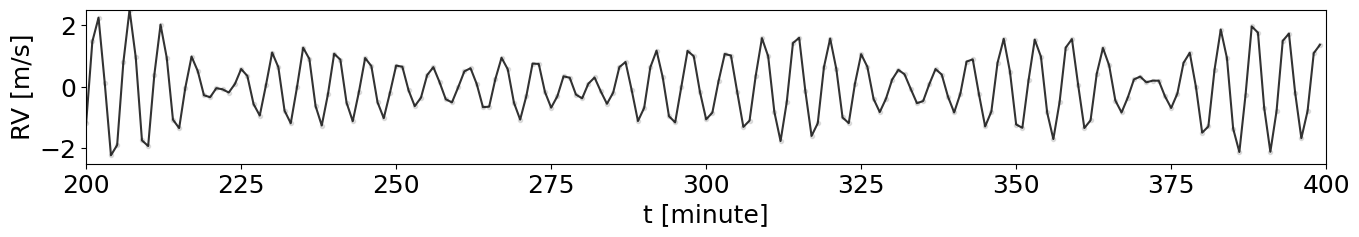

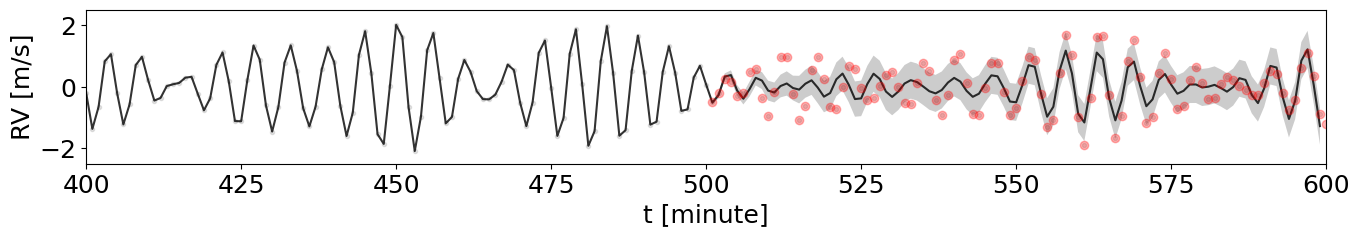

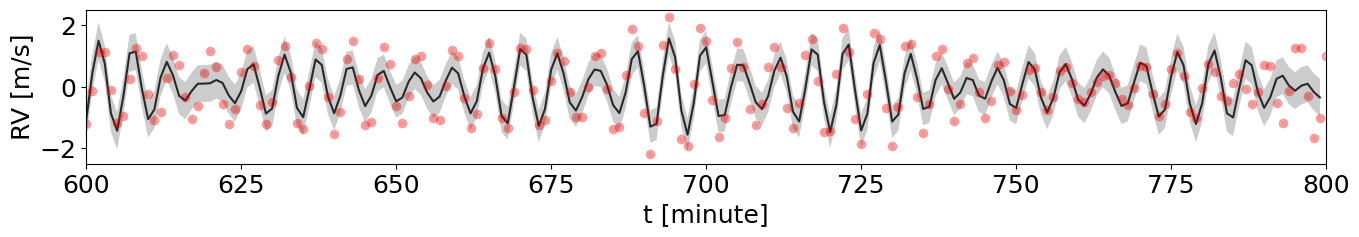

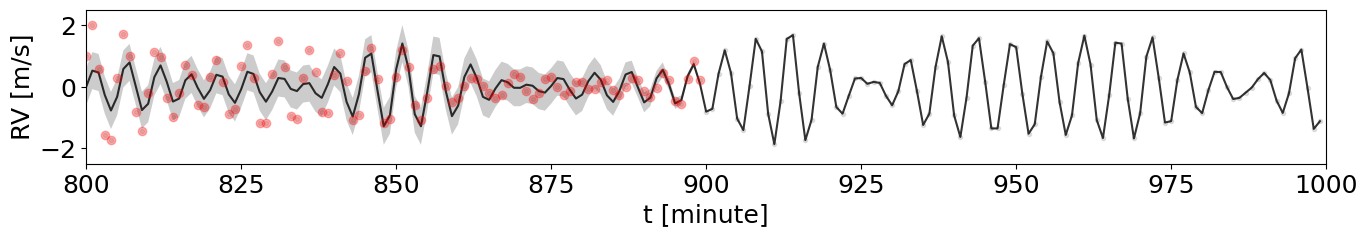

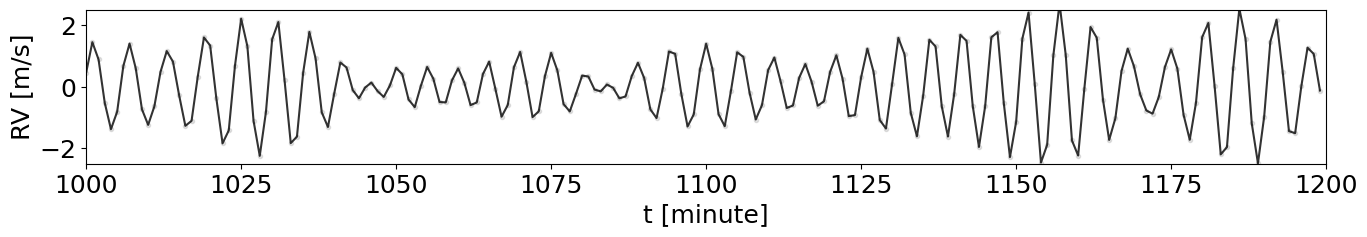

In [274]:
idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

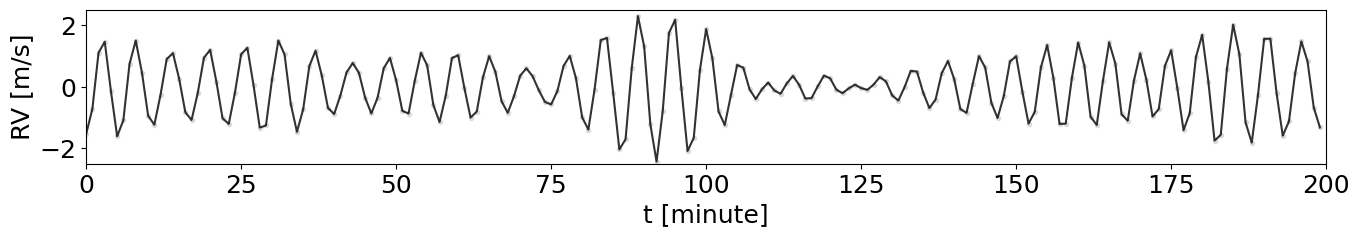

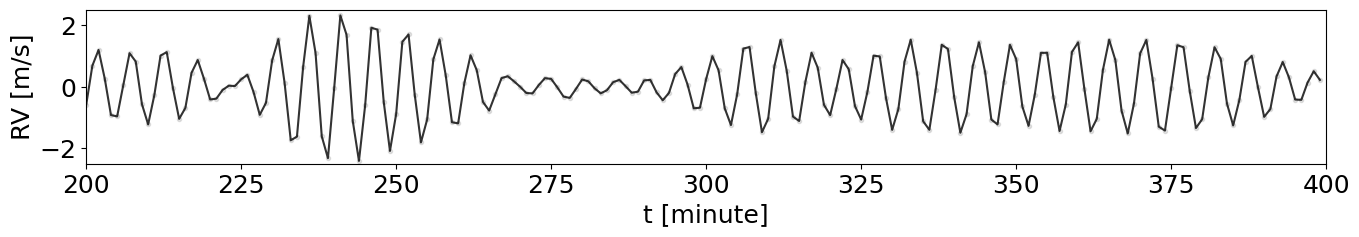

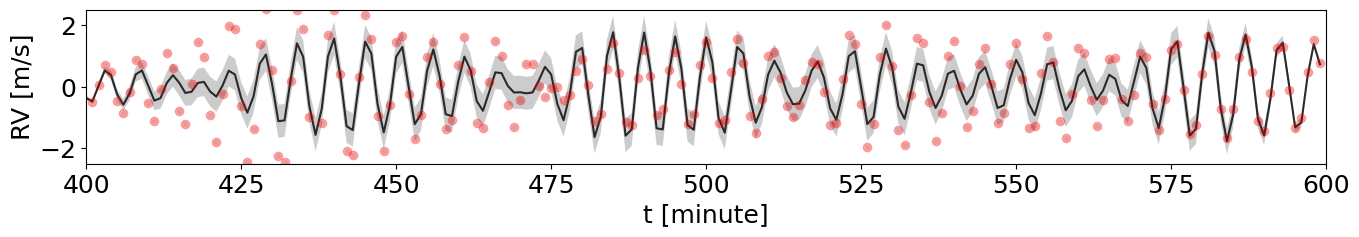

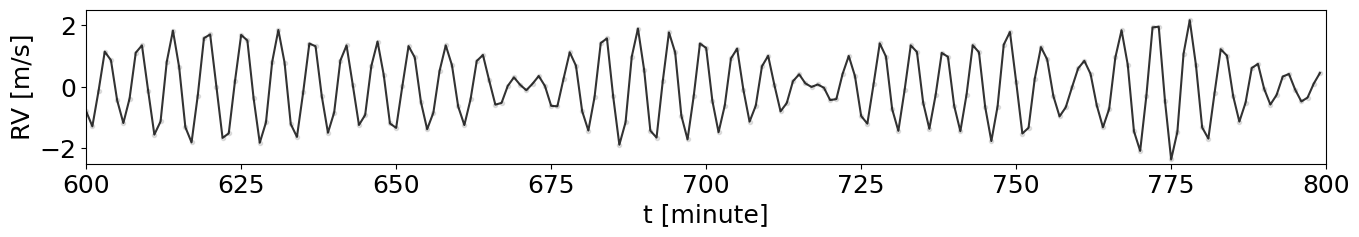

In [199]:
idx_test = ((t > 400) & (t < 600))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp = GaussianProcess(kernel, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

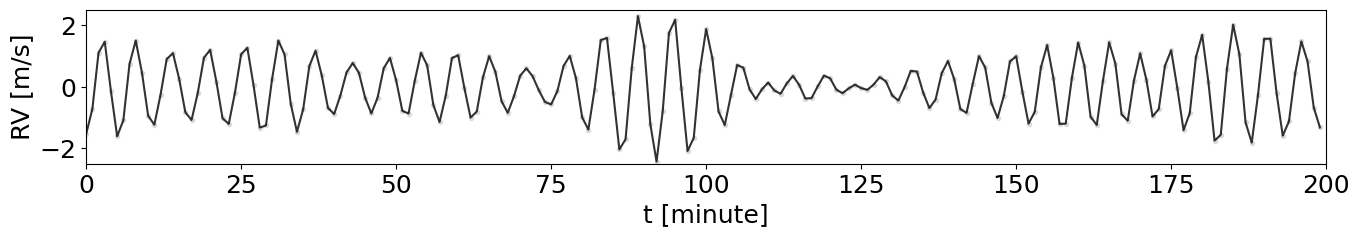

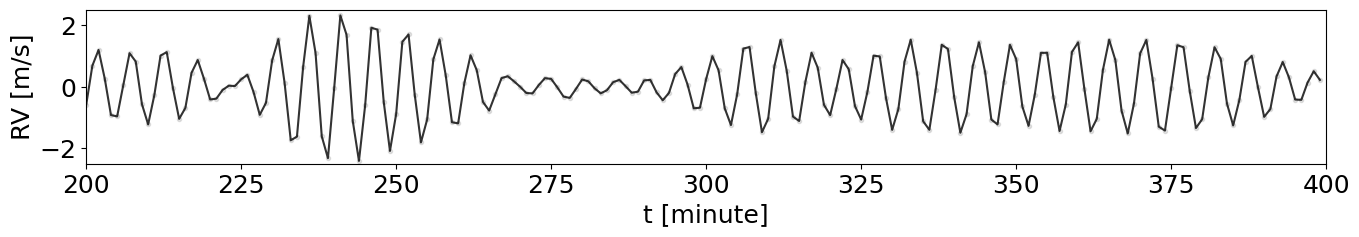

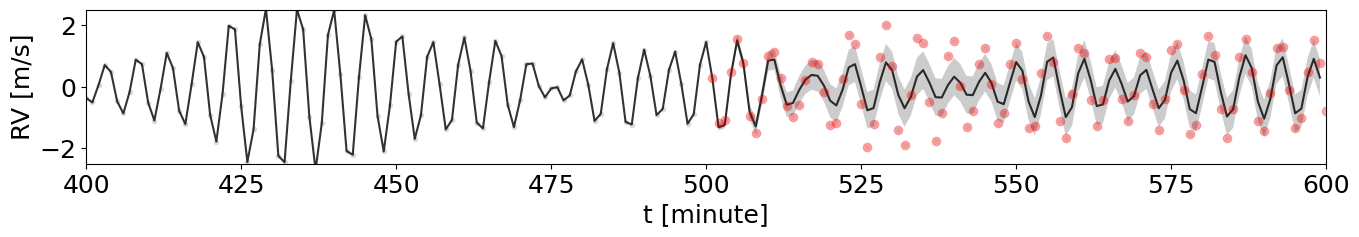

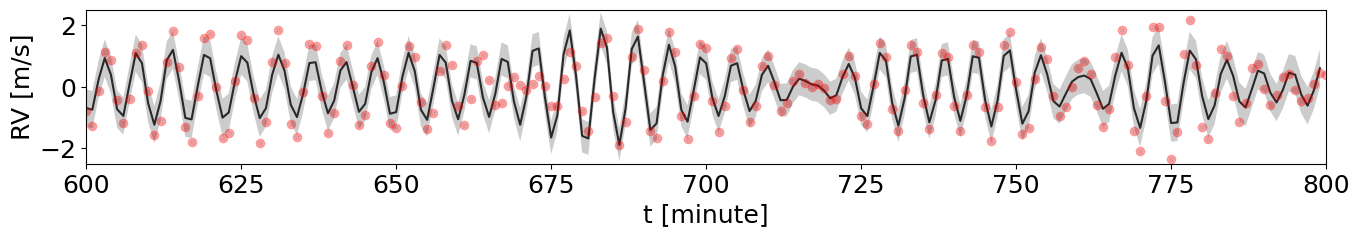

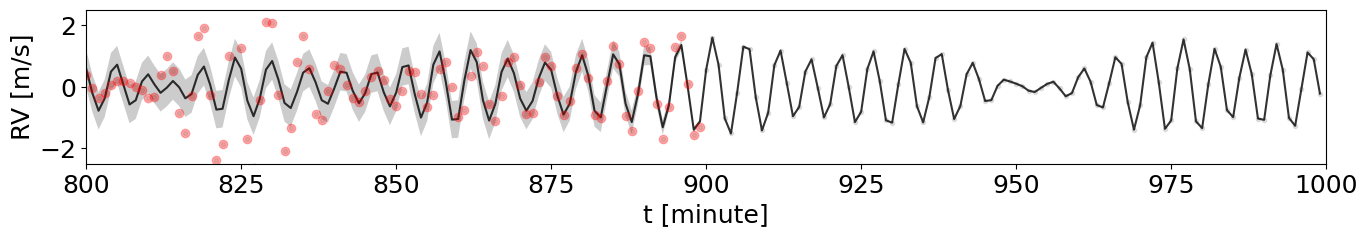

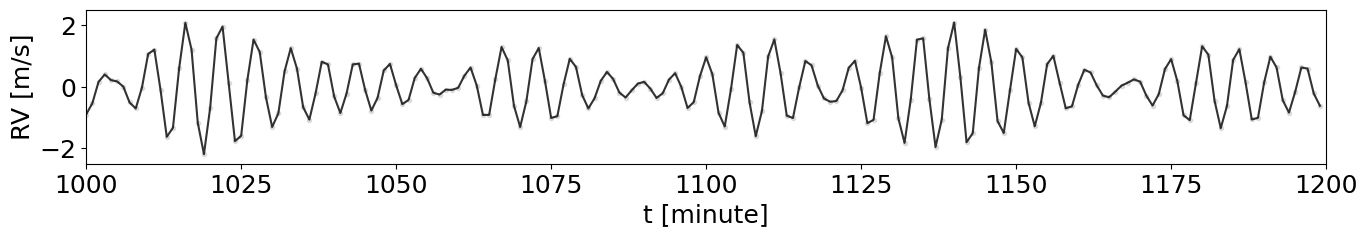

In [200]:
idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp = GaussianProcess(kernel, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

### Q, delta_nu

In [9]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -3467.2893178275394
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-558.2658172, dtype=float64), 'log_delta_nu': DeviceArray(3519.13836708, dtype=float64)}


Final negative log likelihood: -3789.3677153055933
Q 384.4239503139697
delta_nu 134.98712853260378


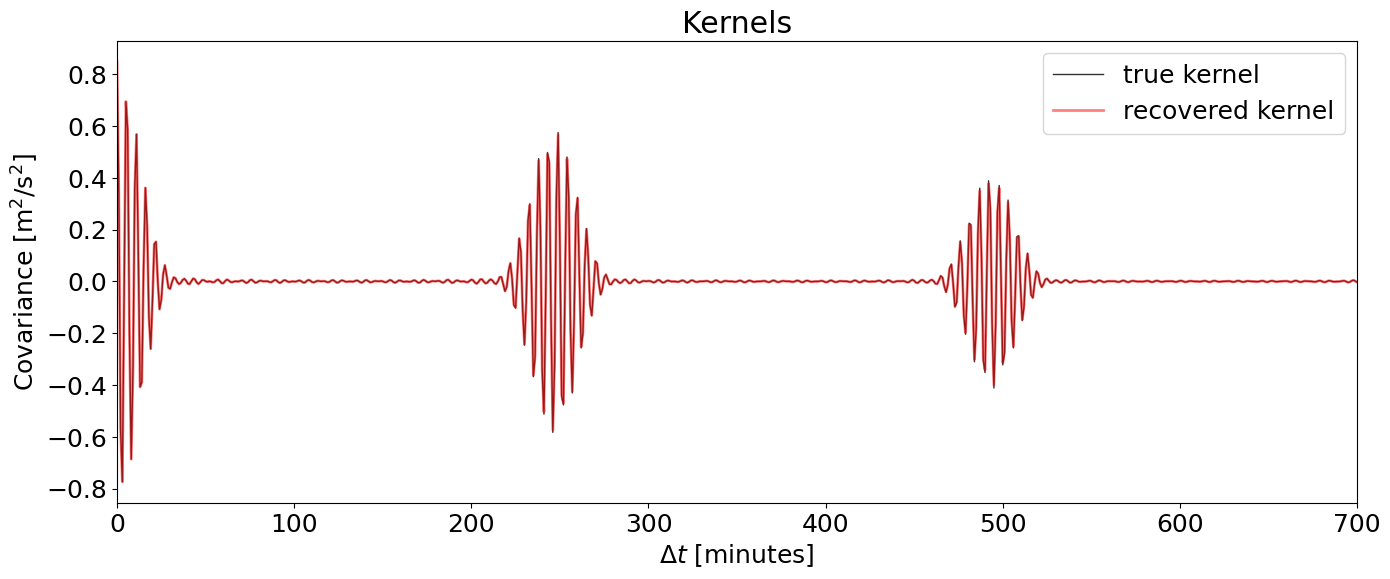

In [10]:
solve()

### Q, nu_max

Initial negative log likelihood: -3352.5056439412906
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-387.48045382, dtype=float64), 'log_nu_max': DeviceArray(-48323.17074038, dtype=float64)}
Final negative log likelihood: -3789.8257220467663
Q 384.6912034760403
nu_max 3081.382819042823


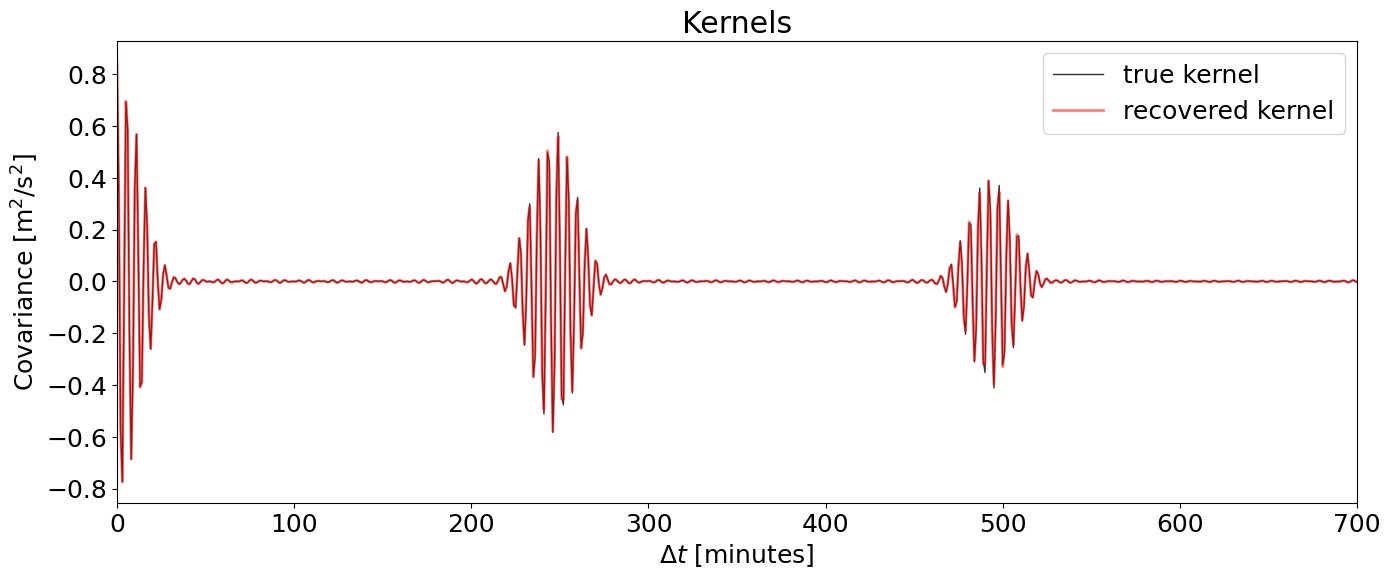

In [11]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A

Initial negative log likelihood: -2089.217253831808
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-5914.56744621, dtype=float64), 'log_Q': DeviceArray(2631.83166588, dtype=float64), 'log_nu_max': DeviceArray(-203791.83658157, dtype=float64)}
Final negative log likelihood: -3789.6434350872432
A 0.3678794411714424
Q 483.4374393667006
nu_max 3081.379612214473


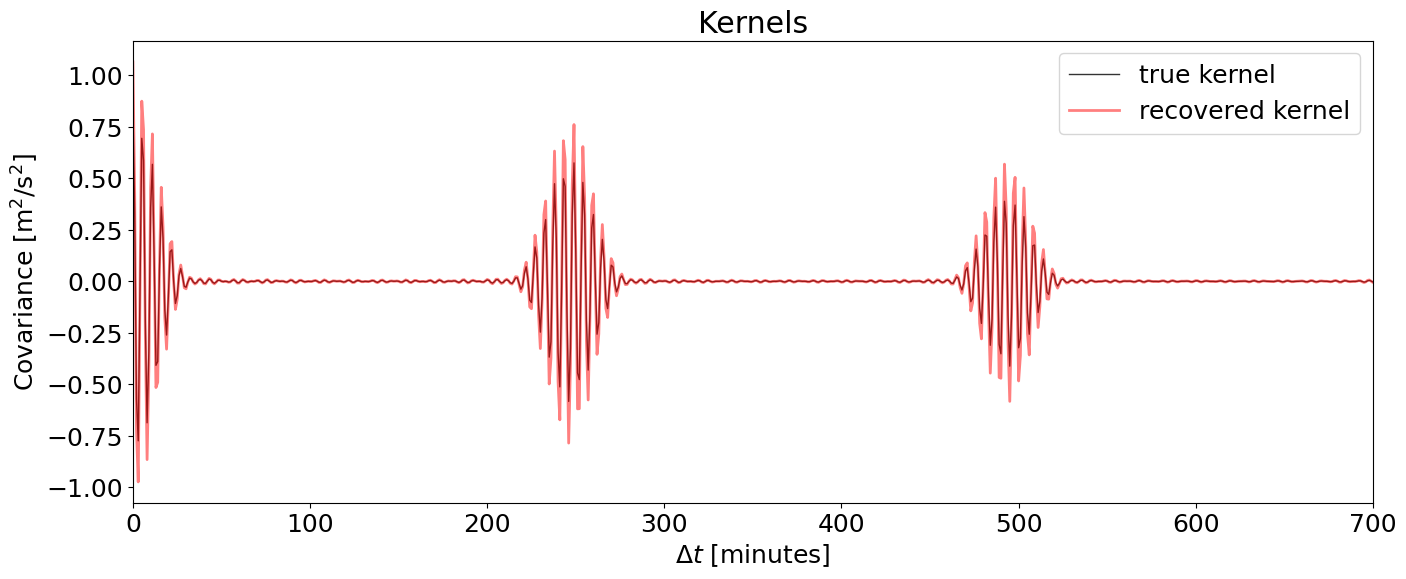

In [12]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [13]:
amp

0.3281255832

### Q, nu_max, A, delta_nu

Initial negative log likelihood: -2120.8289187693745
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-5927.89940872, dtype=float64), 'log_Q': DeviceArray(2596.43913514, dtype=float64), 'log_delta_nu': DeviceArray(4030.67157027, dtype=float64), 'log_nu_max': DeviceArray(-108232.25741808, dtype=float64)}
Final negative log likelihood: -3644.1207416692805
A 0.3678794411714424
Q 413.4778250587807
delta_nu 135.35850062701658
nu_max 3015.0780861958183


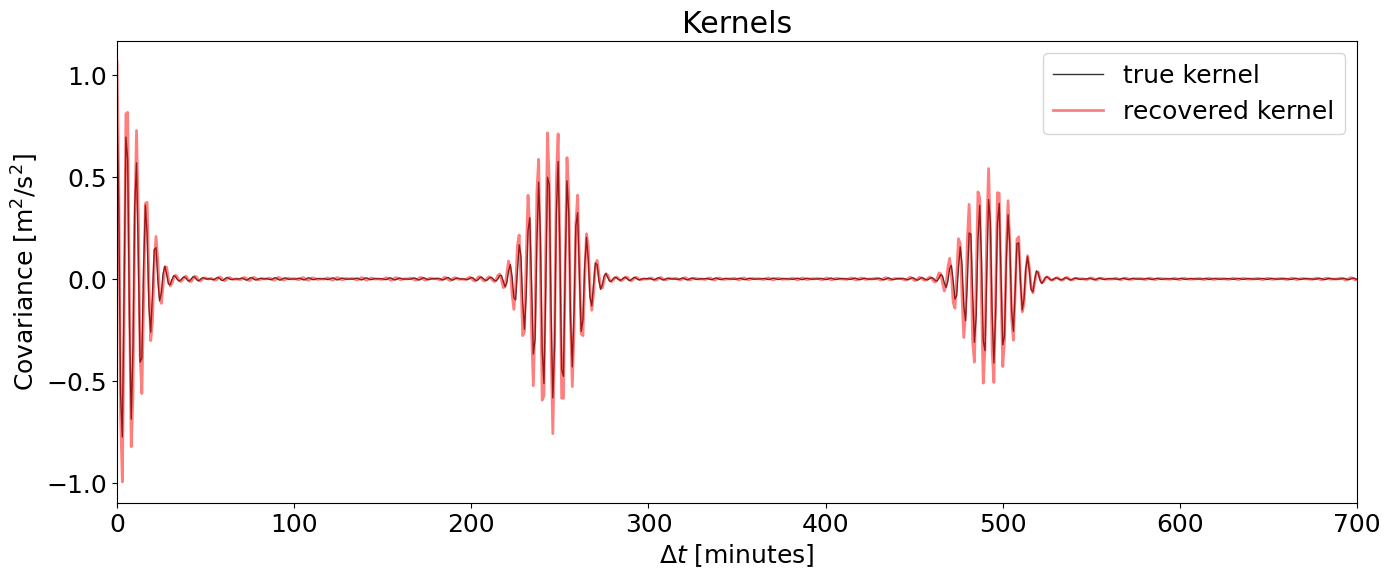

In [14]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W

Initial negative log likelihood: -2042.9750251029045
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-6144.18433157, dtype=float64), 'log_Q': DeviceArray(2686.62307929, dtype=float64), 'log_W': DeviceArray(-4533.5713108, dtype=float64), 'log_delta_nu': DeviceArray(4302.03050892, dtype=float64), 'log_nu_max': DeviceArray(-109250.09737757, dtype=float64)}
Final negative log likelihood: -3671.1430873923537
A 0.3678794411714424
Q 606.8857259125703
W 456.38165832401586
delta_nu 135.31261104669798
nu_max 3015.053653689341


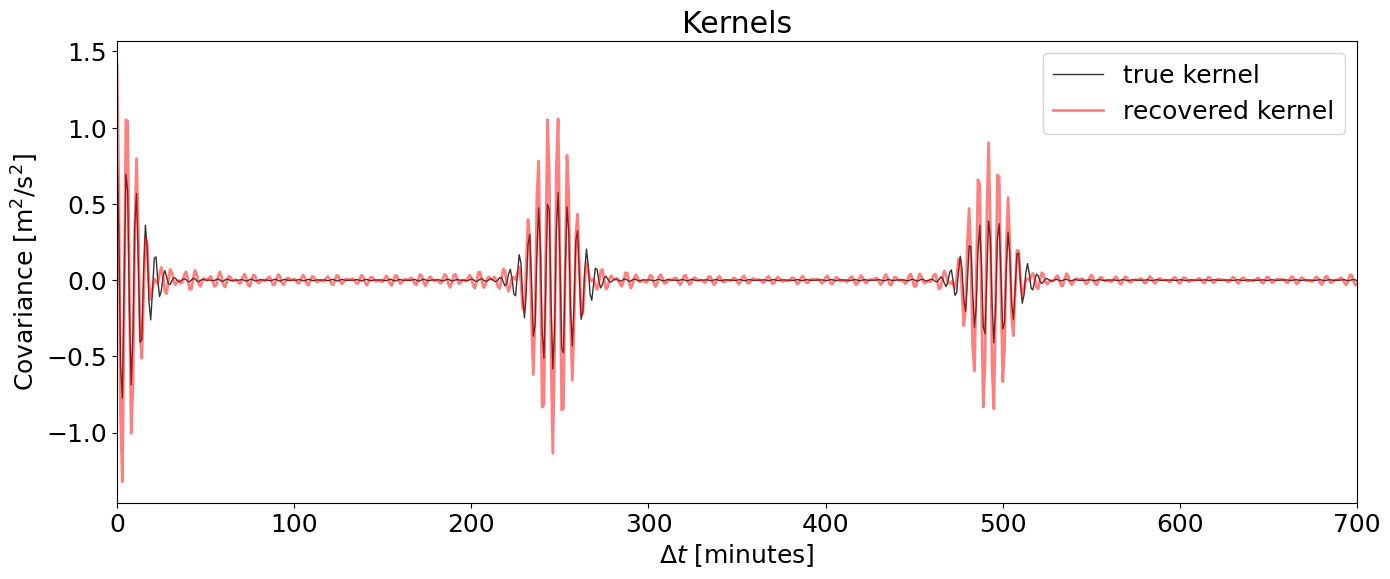

In [15]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W, epsilon

In [177]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(450),
    "log_A": np.log(0.8*amp),
    "log_W": np.log(350),
    "log_nu_max": np.log(3050),
    "log_delta_nu": np.log(136),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)





Initial negative log likelihood: -1705.7205231212902
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-12.39266358, dtype=float64), 'log_A': DeviceArray(-2608.06490753, dtype=float64), 'log_Q': DeviceArray(1305.97887303, dtype=float64), 'log_W': DeviceArray(-1401.26997133, dtype=float64), 'log_delta_nu': DeviceArray(-1573.04199304, dtype=float64), 'log_nu_max': DeviceArray(-40582.88139022, dtype=float64)}


Final negative log likelihood: -1197.4892378876843
lon 1.1844691067953674
A 0.33792929084603235
Q 442.1584503377428
W 321.04147536432396
delta_nu 135.21537998422417
nu_max 3079.6575959896295


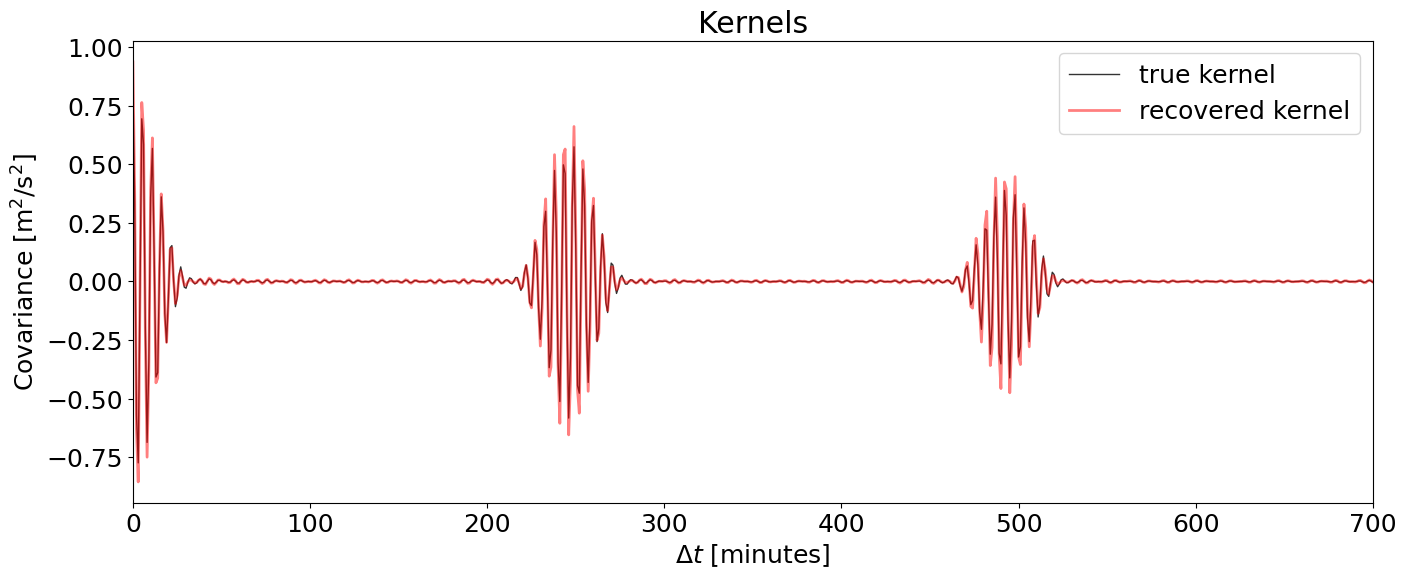

In [178]:
epsilon_l, epsilon_h = jnp.float64([-1, 1])
bounds_l = jnp.log(jnp.array([1e-1,  3e2, 200, 130,  3000.0]))
bounds_h = jnp.log(jnp.array([1,     5e2, 400, 140,  3200.0]))
lower_bounds, upper_bounds = jnp.hstack((epsilon_l, bounds_l)), jnp.hstack((epsilon_h, bounds_h))
bounds = (lower_bounds, upper_bounds)

import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
# soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
soln = solver.run(theta_init, bounds=bounds, X=t_int, y=y_int)
print(f"Final negative log likelihood: {soln.state.fun_val}")

for key, value in soln.params.items():
    print(key[4:], np.exp(value))

model_gp, _ = build_gp(soln.params, t)

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([0,700])
plt.legend()
plt.show()


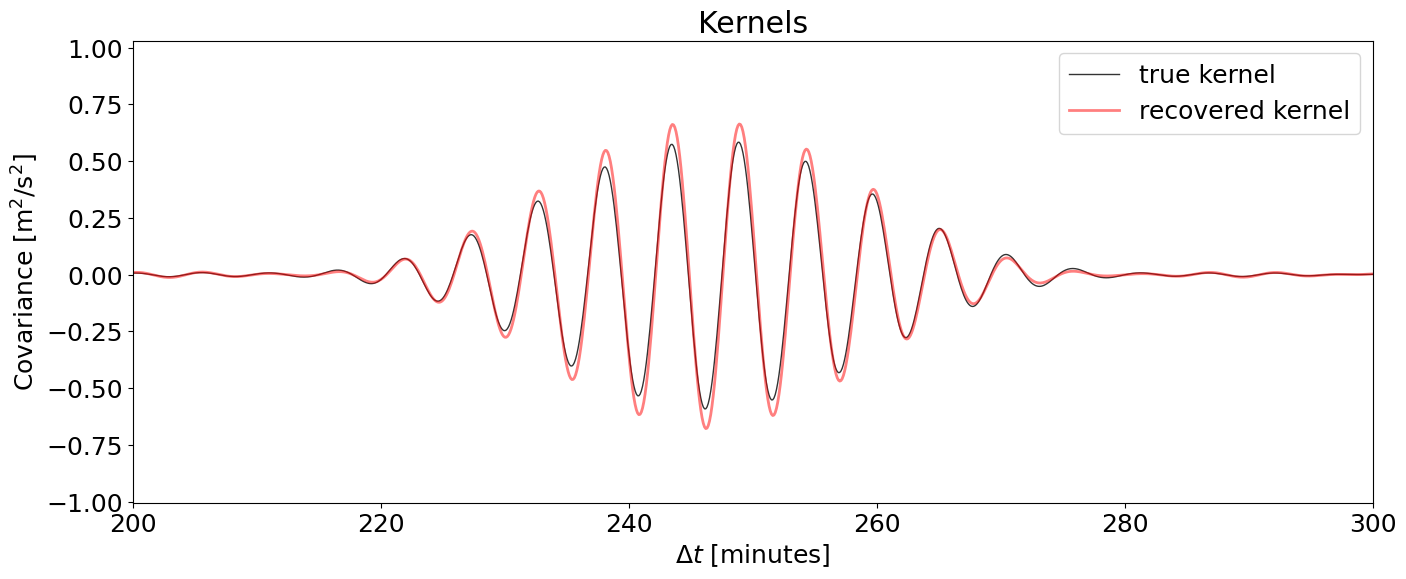

In [194]:
t_kernel = np.linspace(0, 300, 3001)
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t_kernel, kernel(t_kernel, t_kernel[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t_kernel, model_gp.kernel(t_kernel, t_kernel[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([200,300])
plt.legend()
plt.show()

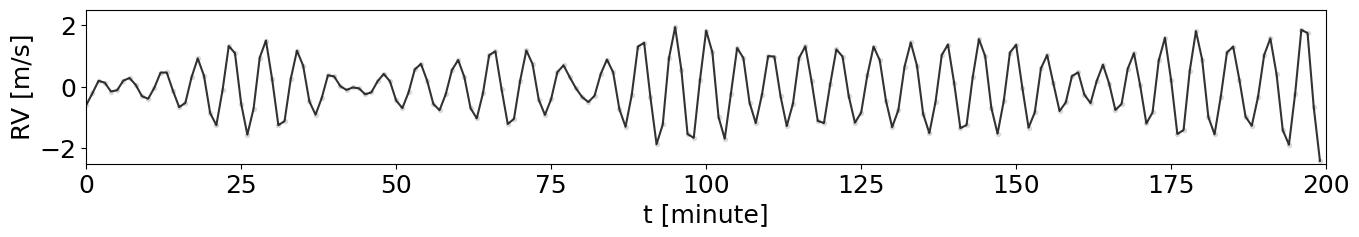

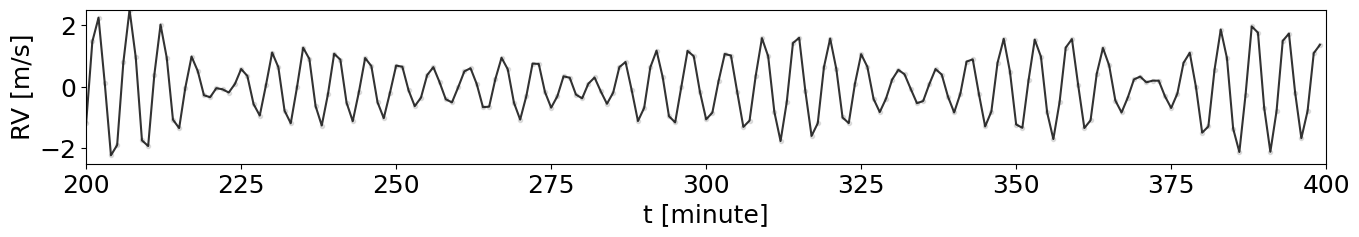

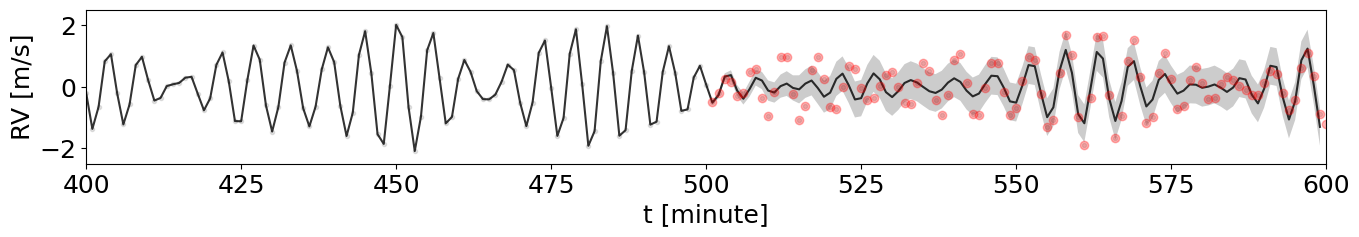

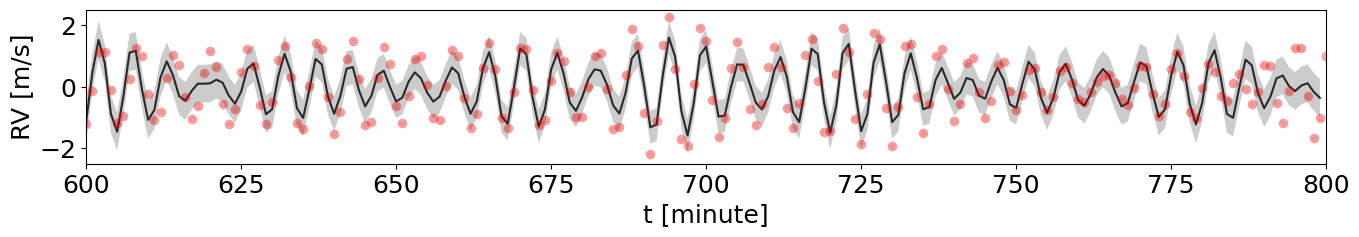

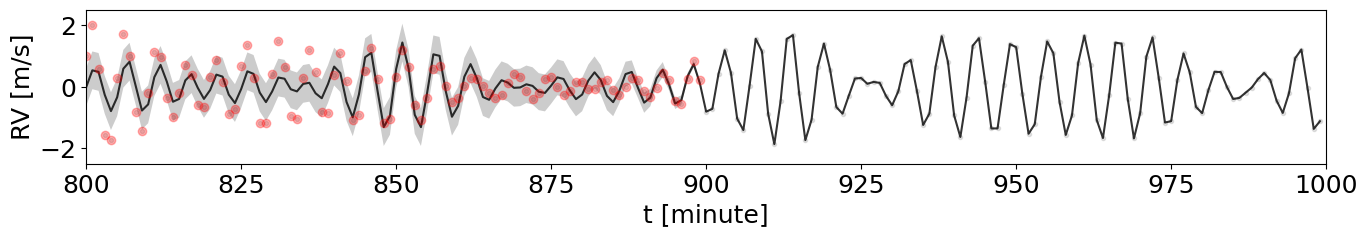

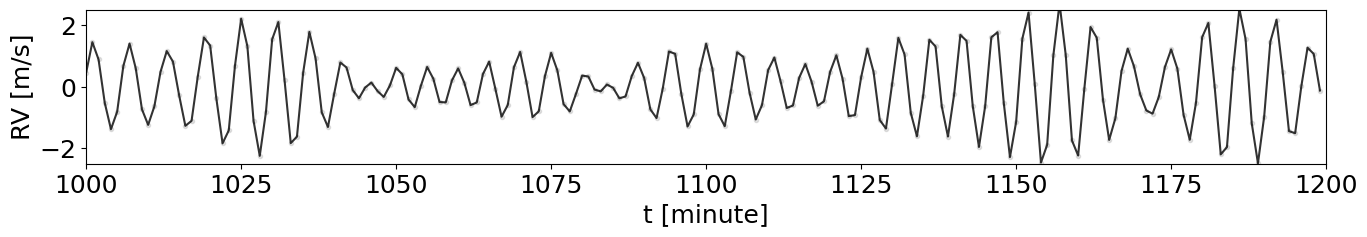

In [12]:
idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

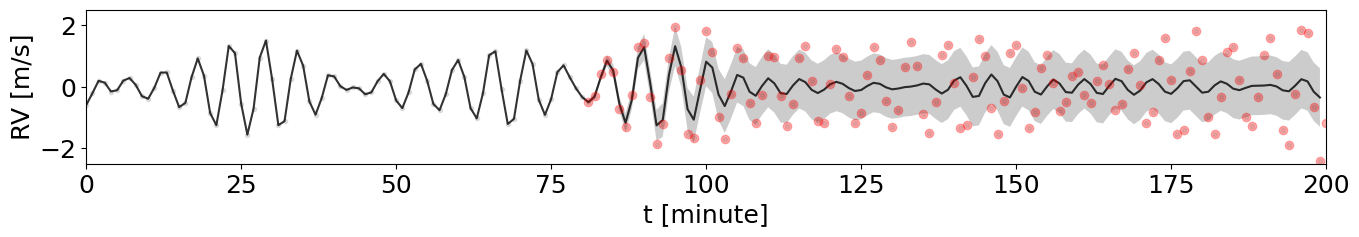

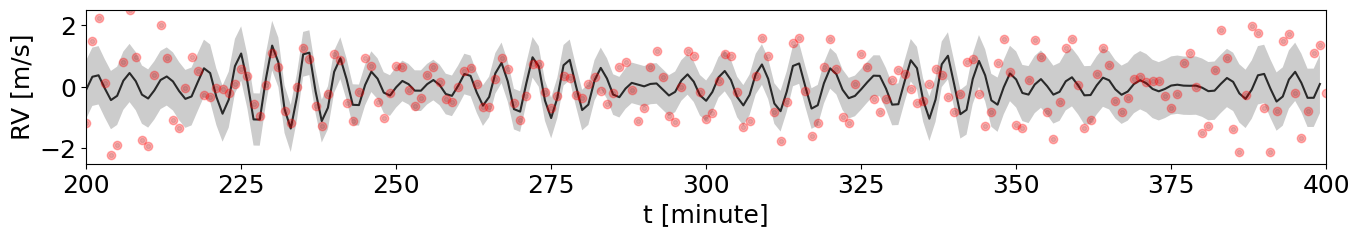

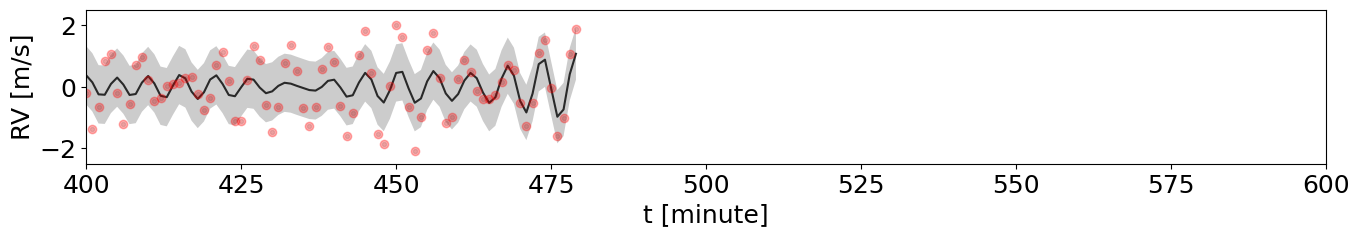

In [184]:
idx_test = ((t_int > 80) & (t_int < 480))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [185]:
np.std(y_int[idx_test] - pred_mean[idx_test])

DeviceArray(0.85508356, dtype=float64)

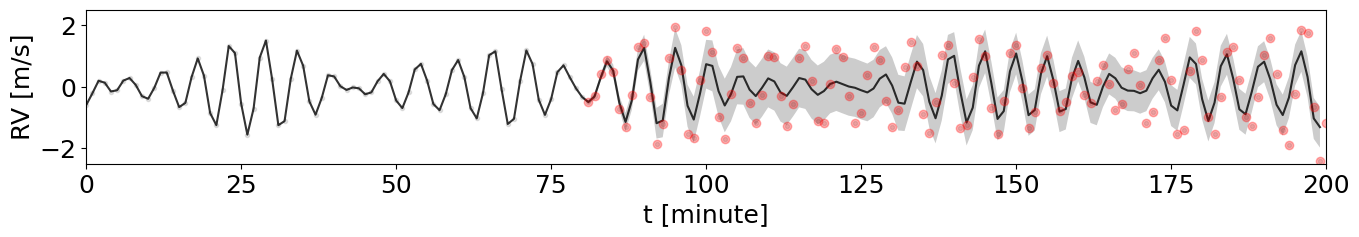

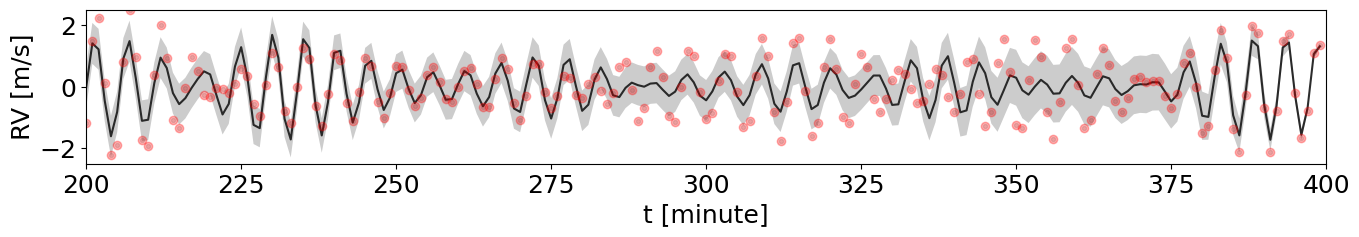

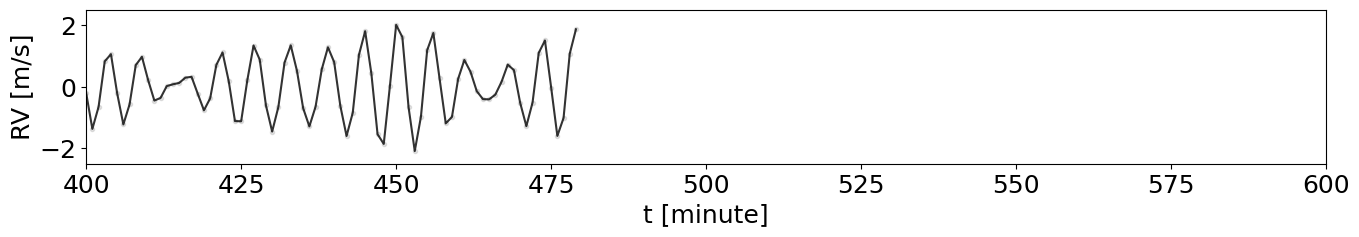

In [186]:
idx_test = ((t_int > 80) & (t_int < 400))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [187]:
np.std(y_int[idx_test] - pred_mean[idx_test])

DeviceArray(0.68980907, dtype=float64)

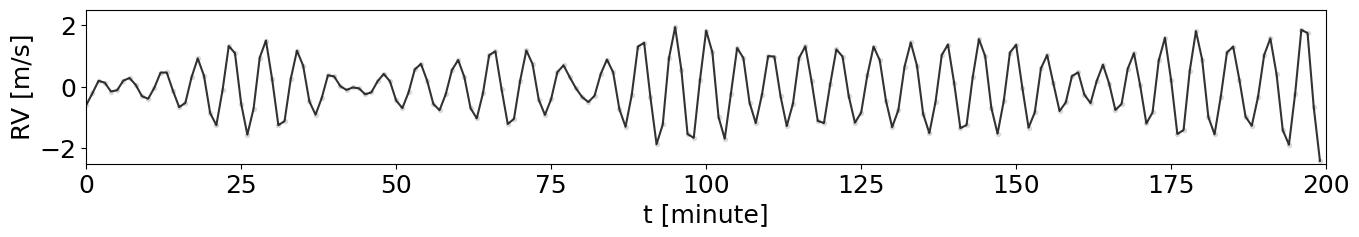

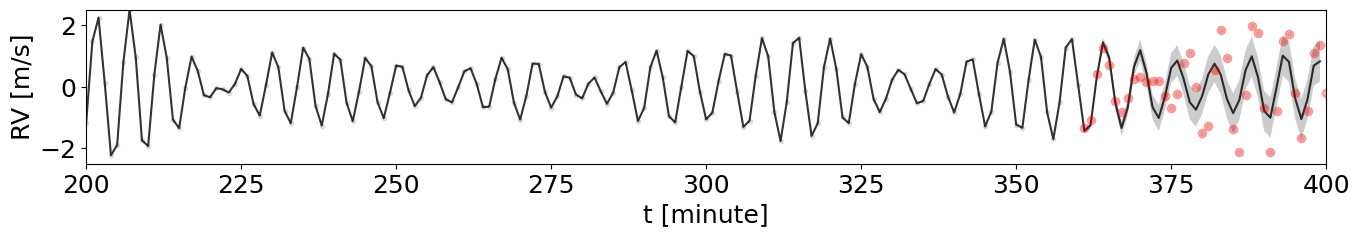

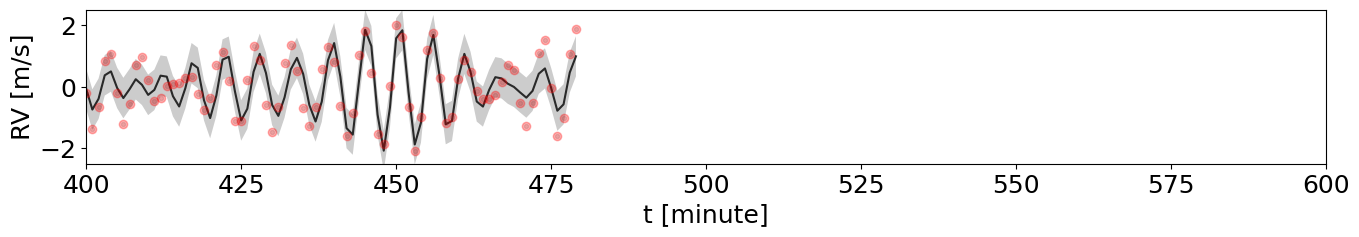

In [188]:
idx_test = ((t_int > 360) & (t_int < 480))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [189]:
np.std(y_int[idx_test] - pred_mean[idx_test])

DeviceArray(0.69432578, dtype=float64)

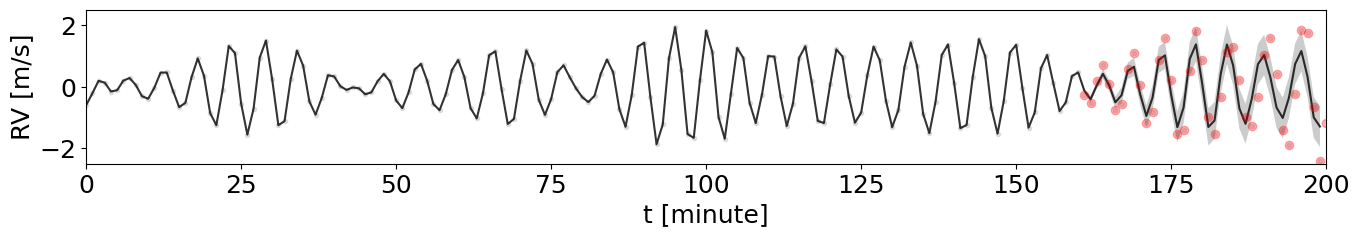

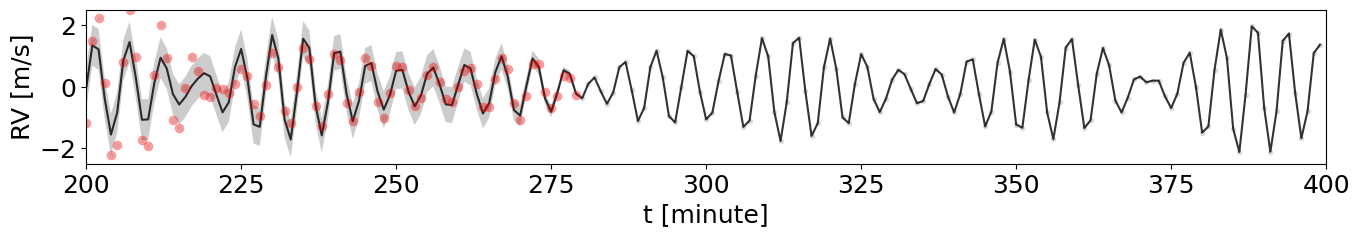

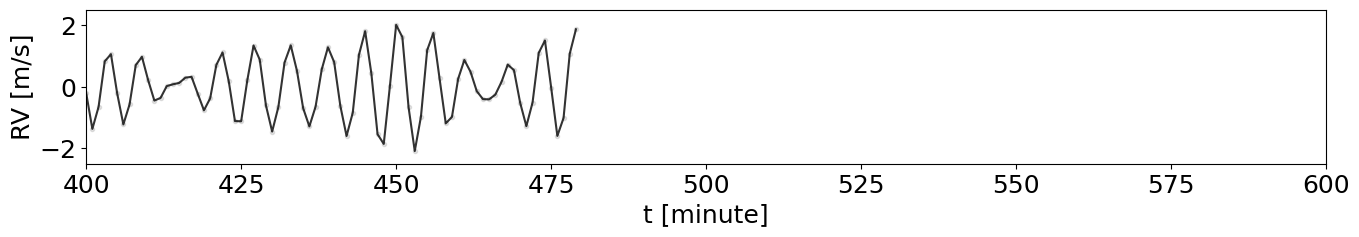

In [190]:
idx_test = ((t_int > 160) & (t_int < 280))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [191]:
np.std(y_int[idx_test] - pred_mean[idx_test])

DeviceArray(0.52753052, dtype=float64)

In [13]:
np.std(y[idx_test] - pred_mean[idx_test])

DeviceArray(0.5503466, dtype=float64)

### +diag

Initial negative log likelihood: 2628.34386063123
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-15.21328763, dtype=float64), 'log_A': DeviceArray(-611.57639015, dtype=float64), 'log_Q': DeviceArray(148.58202064, dtype=float64), 'log_W': DeviceArray(-266.308895, dtype=float64), 'log_delta_nu': DeviceArray(802.30194022, dtype=float64), 'log_diag': DeviceArray(1121.00717334, dtype=float64), 'log_nu_max': DeviceArray(-46922.38048627, dtype=float64)}
Final negative log likelihood: 1907.7990254893139
lon 0.9901731712005065
A 0.3727931938742679
Q 561.2030160326206
W 271.983303097845
delta_nu 135.19874740682624
diag 0.3678794411714424
nu_max 3014.168199332096


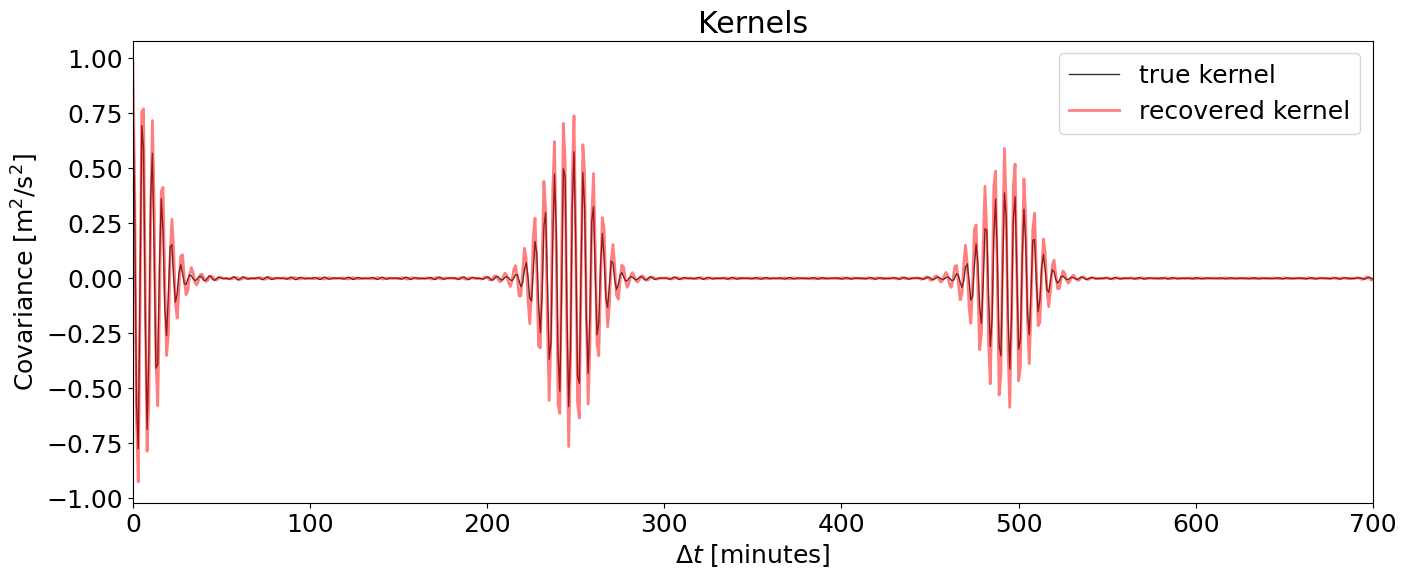

In [17]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"])), kernel           

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Cov

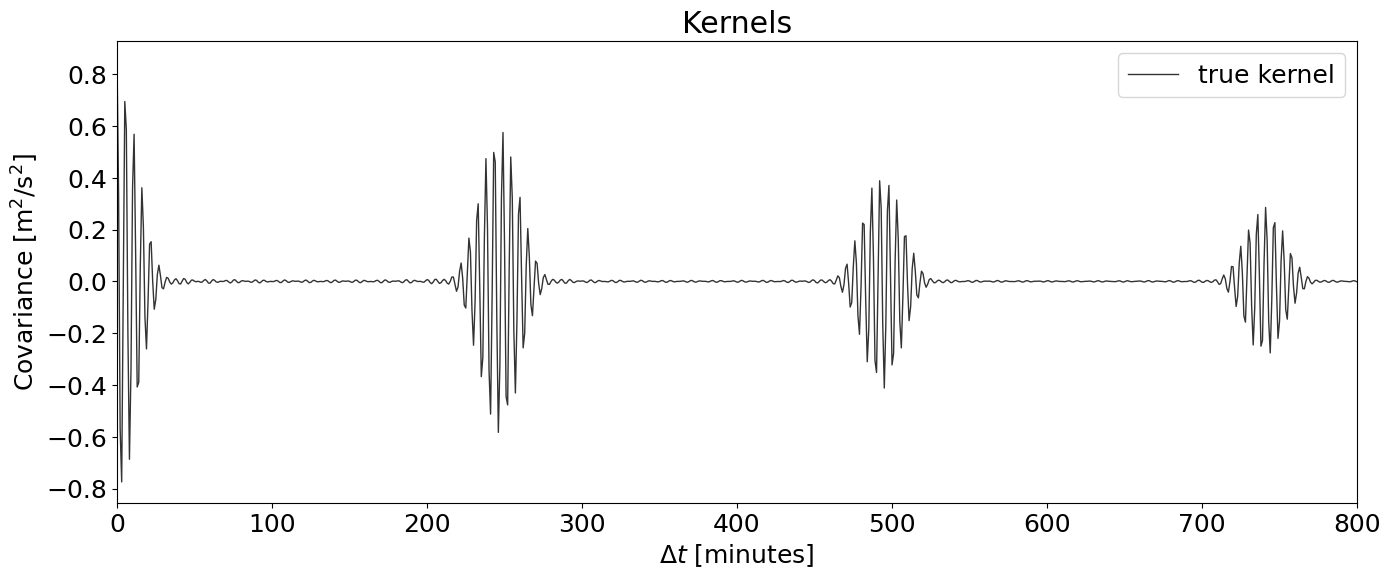

In [109]:
t = np.linspace(0, 3000, 3001)
y_data = kernel(t, t[:1])[:,0]

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([0,800])
plt.legend()
plt.show()

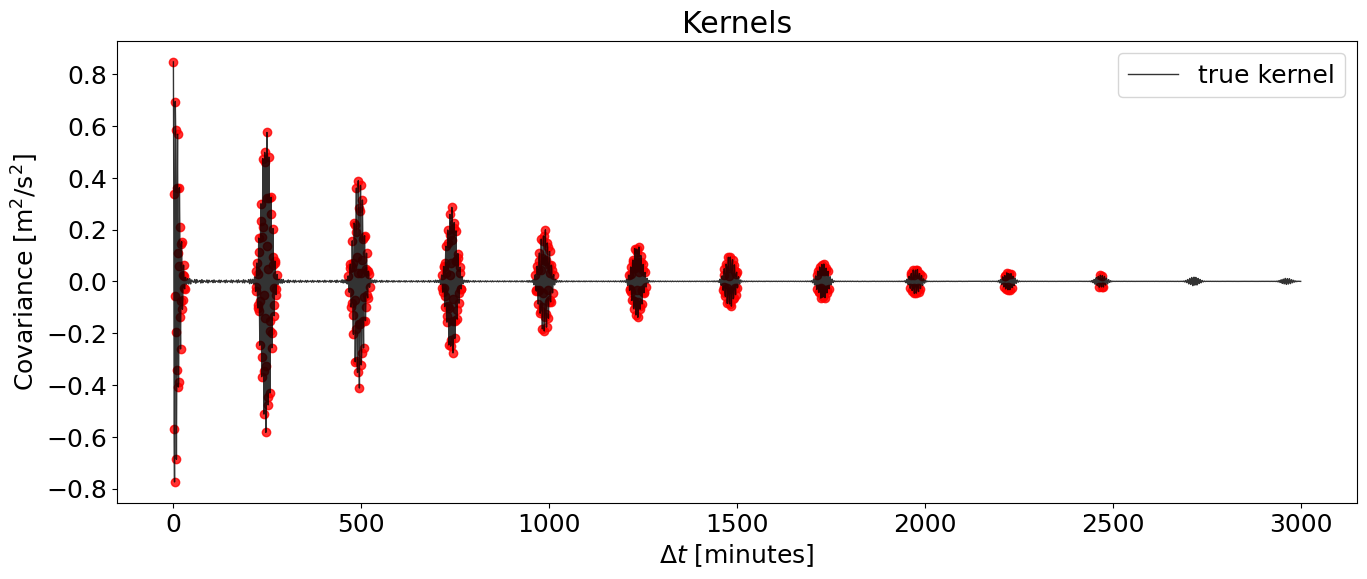

In [110]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))

idx_y = (abs(y_data)>np.std(y_data)/3)
plt.plot(t[idx_y], y_data[idx_y], 'o', lw=1, color='r', alpha=0.8)
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([0,800])
plt.legend()
plt.show()

In [111]:
epsilon, Q, N

(0, 400.0, 15)

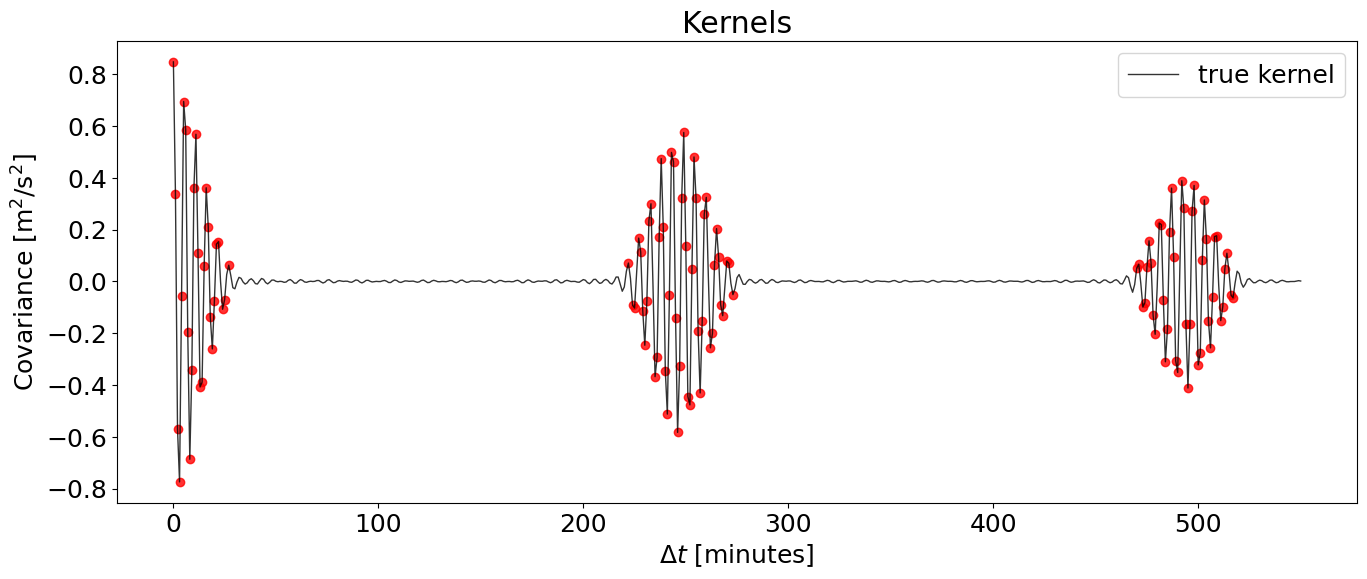

In [116]:
idx = (t<=550)
t = t[idx]
y_data = y_data[idx]

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))

idx_y = (abs(y_data)>np.std(y_data)/3)
plt.plot(t[idx_y], y_data[idx_y], 'o', lw=1, color='r', alpha=0.8)
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([0,800])
plt.legend()
plt.show()

In [117]:
def build_kernal(theta):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)

    return kernel           

# GaussianProcess(
#         kernel, X, diag=jnp.exp(theta["log_diag"]))

def cov_rms(theta, y):
    kernel_model = build_kernal(theta)
    # gp, _ = build_kernal(theta, X)
    rms = jnp.sum((kernel_model(t, t[:1])[:,0] - y)**2)**0.5
    return rms



# def cov_rms(theta, X, y):
#     gp, _ = build_gp(theta, X)
#     rms = jnp.sum((gp(t, t[:1]) - kernel(t, t[:1]))**2)**0.5
#     return rms

theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(420),
    "log_A": np.log(0.8*amp),
    "log_W": np.log(350),
    "log_nu_max": np.log(3050),
    "log_delta_nu": np.log(136),
    "epsilon": np.float64(0.0)
}

In [118]:
# w_init = jnp.zeros(len(theta_init))
# lower_bounds = jnp.ones_like(w_init)* (-1.5)
# upper_bounds = jnp.ones_like(w_init) * jnp.inf
# bounds = (lower_bounds, upper_bounds)

epsilon_l, epsilon_h = jnp.float64([-1, 1])
bounds_l = jnp.log(jnp.array([1e-1,  3e2, 200, 130,  3000.0]))
bounds_h = jnp.log(jnp.array([1,     5e2, 400, 140,  3200.0]))
lower_bounds, upper_bounds = jnp.hstack((epsilon_l, bounds_l)), jnp.hstack((epsilon_h, bounds_h))
bounds = (lower_bounds, upper_bounds)

import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=cov_rms, maxiter=10000) #
soln = solver.run(theta_init, bounds=bounds, y=y_data)
print(f"Final negative log likelihood: {soln.state.fun_val}")

for key, value in soln.params.items():
    print(key[4:], np.exp(value))

# model_gp, _ = build_gp(soln.params, t)

Final negative log likelihood: 0.6842674738305128
lon 0.3678794411714424
A 0.3199653337901374
Q 409.5031985473704
W 314.1547508809229
delta_nu 134.9959460577418
nu_max 3014.3550565521045


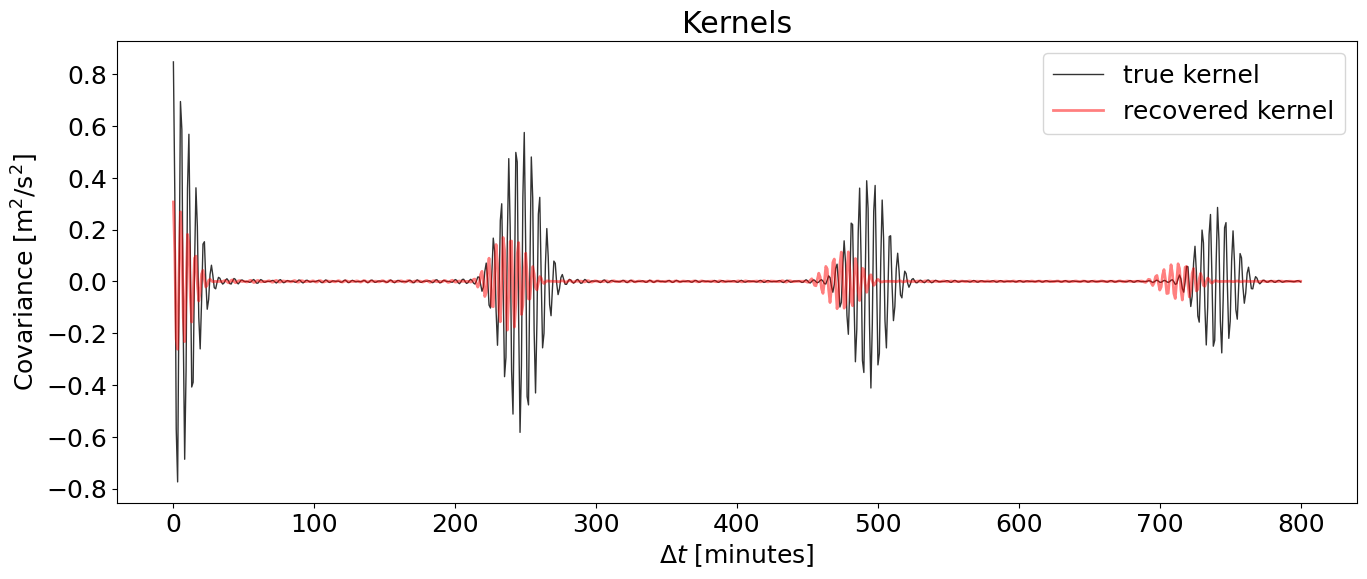

In [115]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([0,700])
plt.legend()
plt.show()

In [216]:
# plt.rcParams.update({'font.size': 18})
# fig = plt.figure(figsize=(16, 6))
# plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
# plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
# plt.title('Kernels')
# plt.xlabel(r'$\Delta t$ [minutes]')
# plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# # plt.xlim([700,1400])
# plt.xlim([0,700])
# plt.legend()
# plt.show()

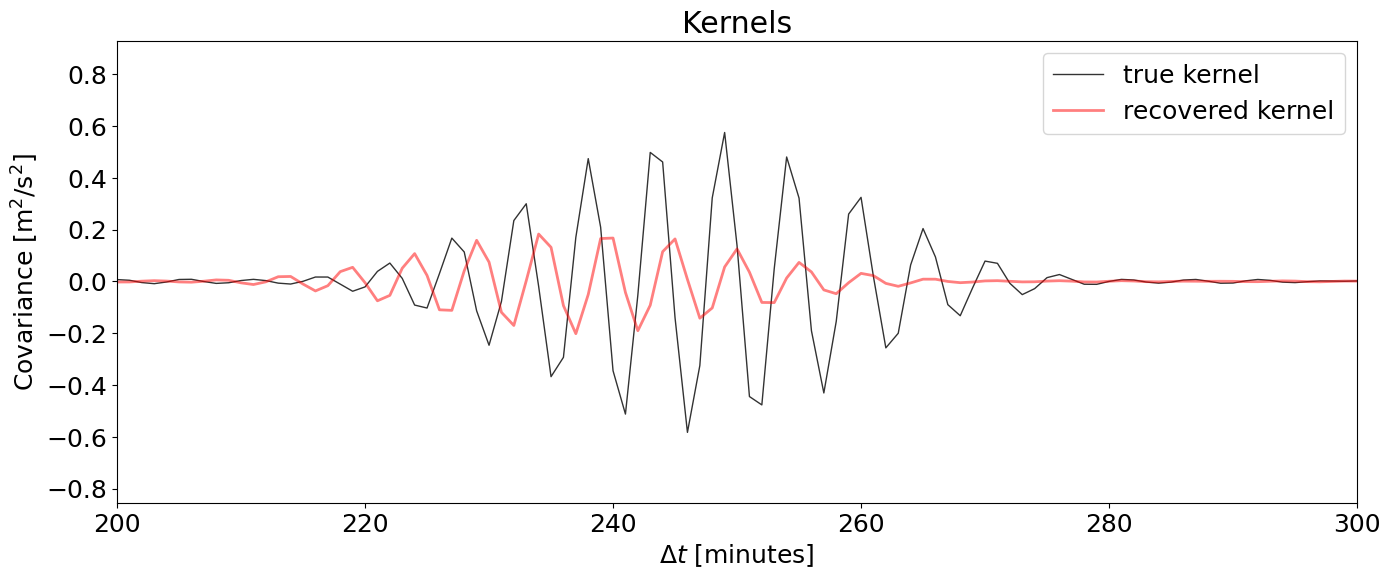

In [98]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([200,300])
plt.legend()
plt.show()

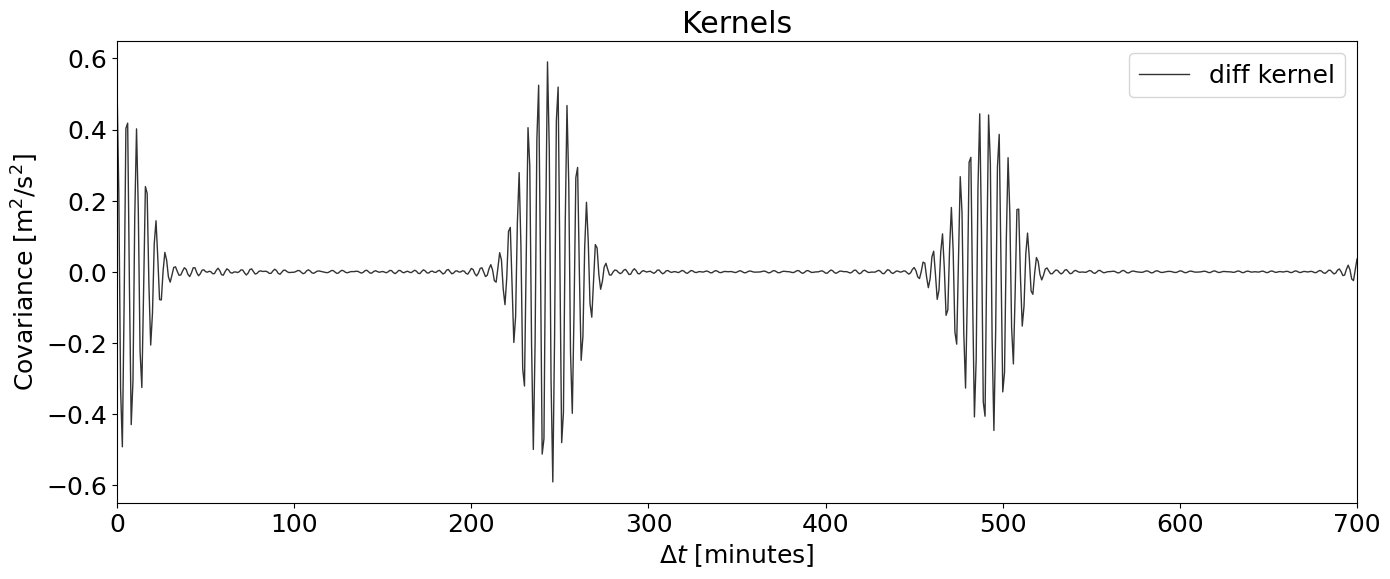

In [99]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data- build_kernal(soln.params)(t, t[:1])[:,0], '-', lw=1, color='k', alpha=0.8, label='diff kernel')
# plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([700,1400])
plt.xlim([0,700])
plt.legend()
plt.show()

In [102]:
# build_kernal(soln.params)(t, t[:1])[:,0][idx_y] - y_data[idx_y]

In [253]:
cov_rms(soln.params, y_data)

DeviceArray(0.68426908, dtype=float64)

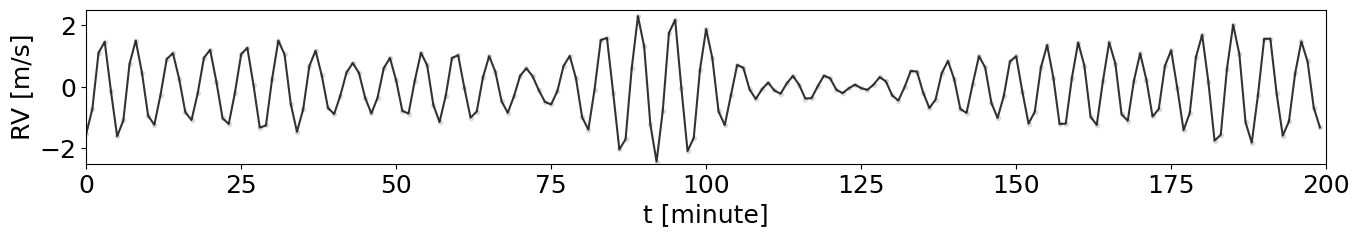

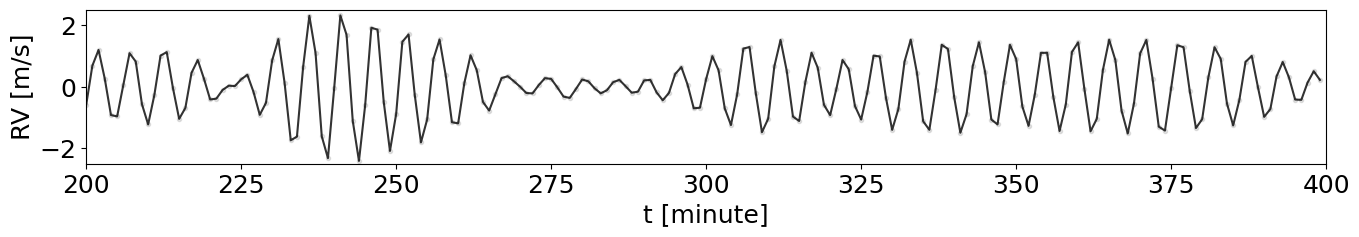

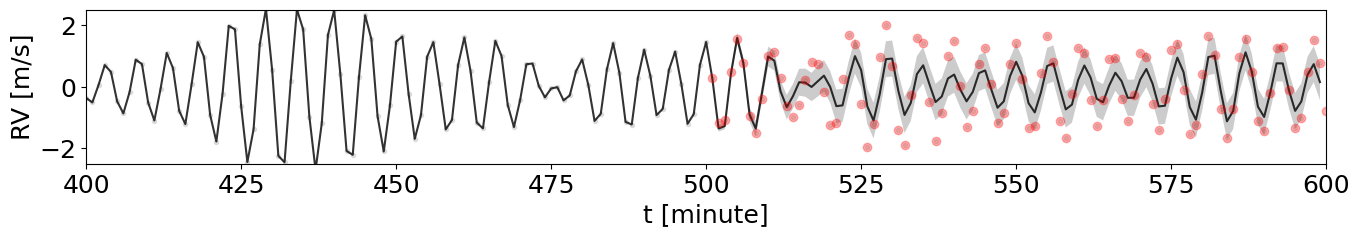

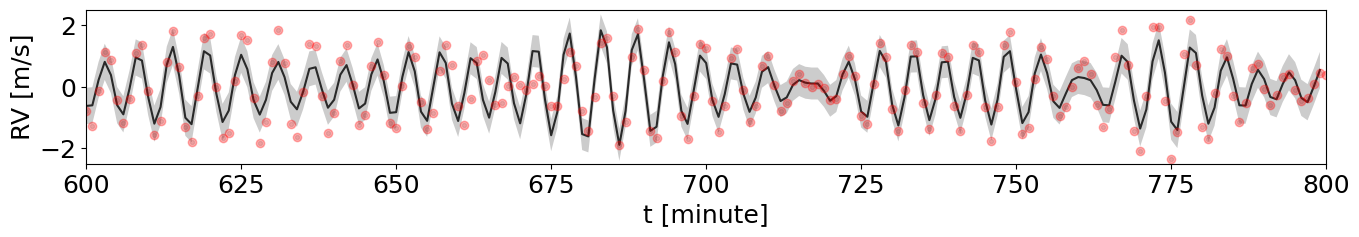

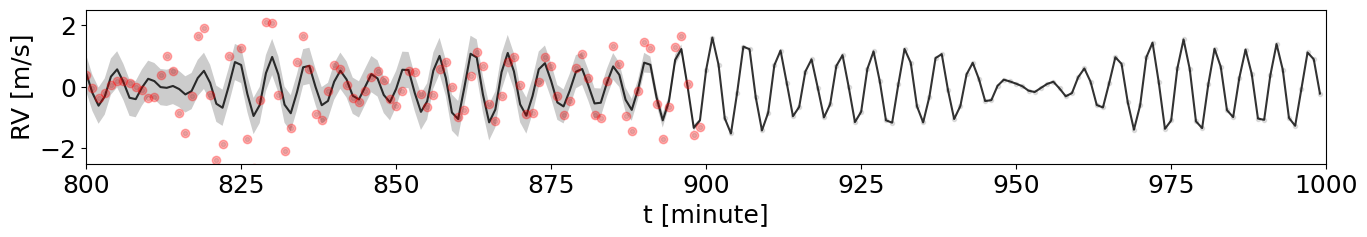

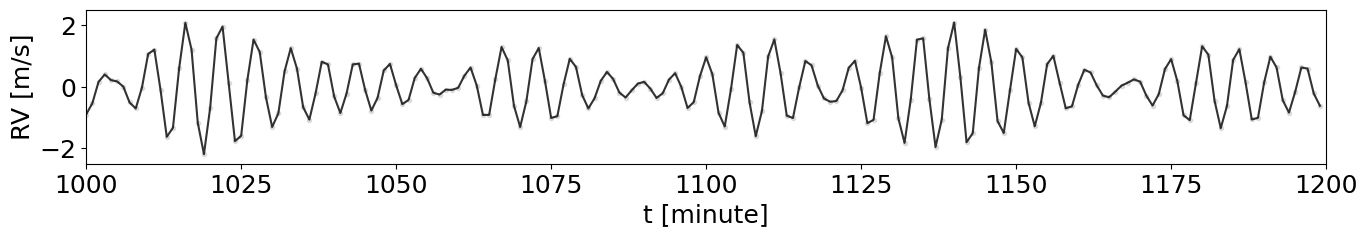

In [254]:
t = np.linspace(0, 3000, 3001)

idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [255]:
np.std(y[idx_test] - pred_mean[idx_test])

DeviceArray(0.59605354, dtype=float64)